In [40]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Paths
image_folder = '/Users/shreejakikkisetti/Downloads/SkinSampleData'  # Replace with the folder path to your images
csv_file = 'Labels.csv'  # Replace with your CSV file path

# Load CSV with labels
data = pd.read_csv(csv_file)

# Define a function to load images
def load_images(image_folder, image_names, target_size=(128, 128)):
    images = []
    for img_name in image_names:
        img_path = os.path.join(image_folder, img_name + '.png')  # Assuming .jpg images
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize the image
        images.append(img_array)
    return np.array(images)

# Load images
image_names = data['Pic Label']  # Assuming your CSV has a column called 'image_name'
images = load_images(image_folder, image_names)

# Extract labels
skin_tone_labels = pd.get_dummies(data['Skin Tone']).values  # One-hot encode skin tone
skin_texture_labels = pd.get_dummies(data['Skin Texture']).values  # One-hot encode skin texture


In [41]:
skin_tone_labels


array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]], dtype=uint8)

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (128, 128, 3)  # Image dimensions

# Define the model
inputs = layers.Input(shape=input_shape)

# Convolutional base
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

# Output 1: Skin Tone
tone_output = layers.Dense(3, activation='softmax', name='skin_tone')(x)  # 3 classes: light, medium, dark

# Output 2: Skin Texture
texture_output = layers.Dense(3, activation='softmax', name='skin_texture')(x)  # 3 classes: normal, combination, oily

# Define the model with two outputs
model = models.Model(inputs=inputs, outputs=[tone_output, texture_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'skin_tone': 'categorical_crossentropy', 'skin_texture': 'categorical_crossentropy'},
              metrics={'skin_tone': 'accuracy', 'skin_texture': 'accuracy'})

# Model summary
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 126, 126, 32)         896       ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 32)           0         ['conv2d_9[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 61, 61, 64)           18496     ['max_pooling2d_9[0][0]'

In [43]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split

# Split images and labels
X_train, X_val, y_train_tone, y_val_tone, y_train_texture, y_val_texture = train_test_split(
    images, skin_tone_labels, skin_texture_labels, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train, {'skin_tone': y_train_tone, 'skin_texture': y_train_texture},
    validation_data=(X_val, {'skin_tone': y_val_tone, 'skin_texture': y_val_texture}),
    epochs=10,  # Adjust based on your dataset size
    batch_size=32
)


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.1902 - skin_tone_loss: 1.0946 - skin_texture_loss: 1.0957 - skin_tone_accuracy: 0.4375 - skin_texture_accuracy: 0.3750 - val_loss: 2.8984 - val_skin_tone_loss: 1.6939 - val_skin_texture_loss: 1.2044 - val_skin_tone_accuracy: 0.2500 - val_skin_texture_accuracy: 0.2500
Epoch 2/10
1/1 [==============================] - 0s 188ms/step - loss: 2.3776 - skin_tone_loss: 1.3115 - skin_texture_loss: 1.0661 - skin_tone_accuracy: 0.4375 - skin_texture_accuracy: 0.3125 - val_loss: 2.1348 - val_skin_tone_loss: 1.0975 - val_skin_texture_loss: 1.0373 - val_skin_tone_accuracy: 0.5000 - val_skin_texture_accuracy: 0.7500
Epoch 3/10
1/1 [==============================] - 0s 186ms/step - loss: 2.1658 - skin_tone_loss: 1.1093 - skin_texture_loss: 1.0564 - skin_tone_accuracy: 0.3750 - skin_texture_accuracy: 0.6875 - val_loss: 2.0375 - val_skin_tone_loss: 1.0309 - val_skin_texture_loss: 1.0066 - val_skin_tone_accuracy: 0.5000 - val_skin_te

In [44]:
# Evaluate the model
results = model.evaluate(X_val, {'skin_tone': y_val_tone, 'skin_texture': y_val_texture})
print(f"Validation loss and accuracy: {results}")

1/1 [==============================] - 0s 36ms/step - loss: 2.0092 - skin_tone_loss: 1.1745 - skin_texture_loss: 0.8348 - skin_tone_accuracy: 0.5000 - skin_texture_accuracy: 0.7500
Validation loss and accuracy: [2.0092196464538574, 1.1744693517684937, 0.8347503542900085, 0.5, 0.75]


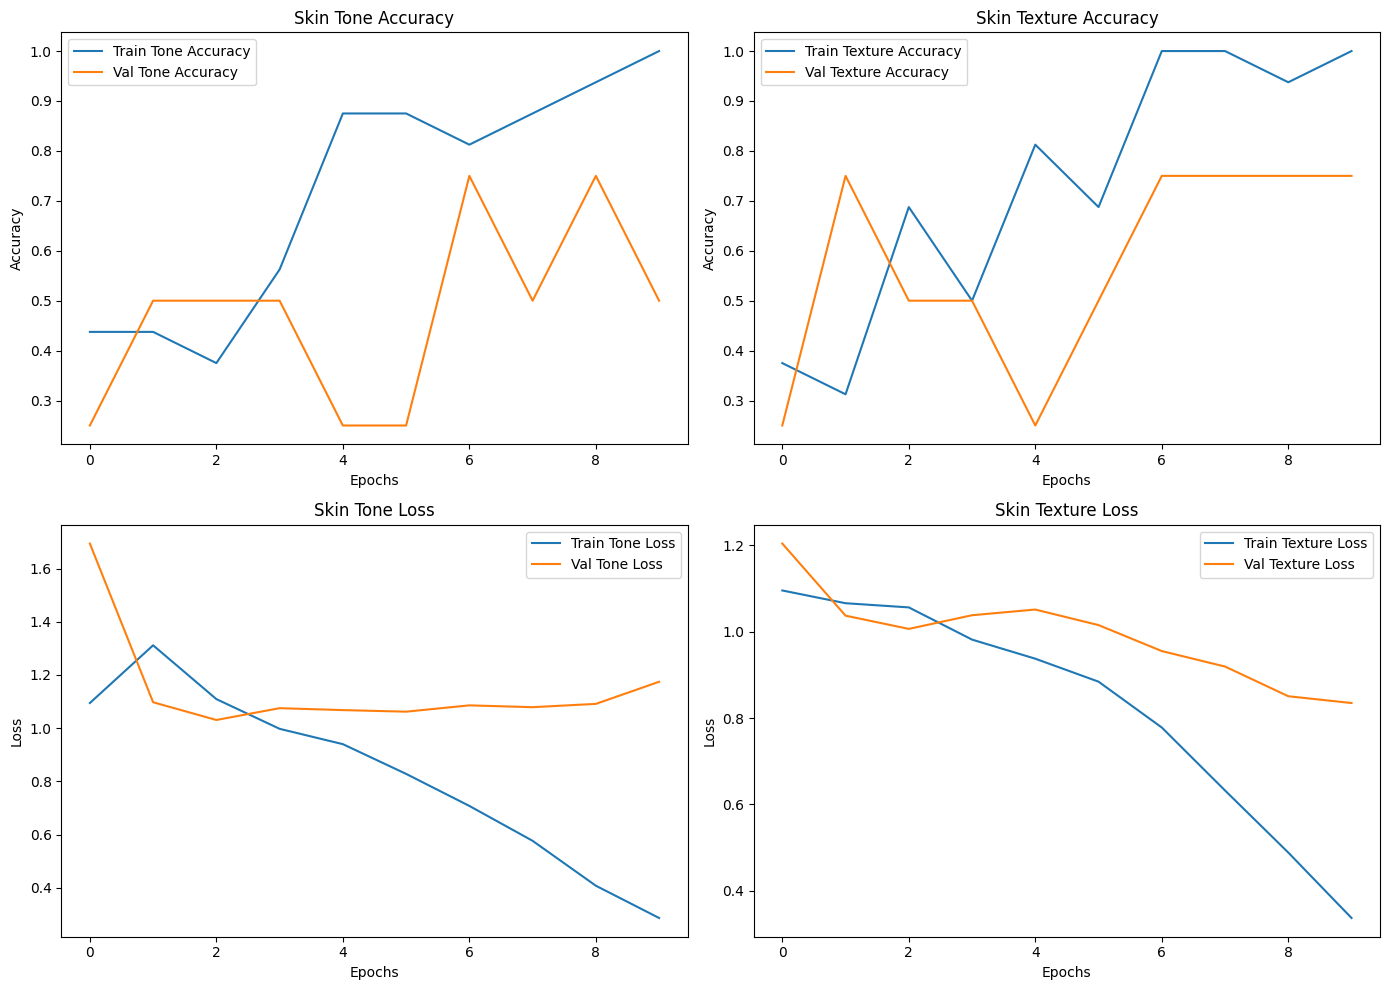

In [45]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_training_history(history):
    # Plot accuracy for skin tone and skin texture
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Accuracy
    axs[0, 0].plot(history.history['skin_tone_accuracy'], label='Train Tone Accuracy')
    axs[0, 0].plot(history.history['val_skin_tone_accuracy'], label='Val Tone Accuracy')
    axs[0, 0].set_title('Skin Tone Accuracy')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend()

    axs[0, 1].plot(history.history['skin_texture_accuracy'], label='Train Texture Accuracy')
    axs[0, 1].plot(history.history['val_skin_texture_accuracy'], label='Val Texture Accuracy')
    axs[0, 1].set_title('Skin Texture Accuracy')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()

    # Loss
    axs[1, 0].plot(history.history['skin_tone_loss'], label='Train Tone Loss')
    axs[1, 0].plot(history.history['val_skin_tone_loss'], label='Val Tone Loss')
    axs[1, 0].set_title('Skin Tone Loss')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()

    axs[1, 1].plot(history.history['skin_texture_loss'], label='Train Texture Loss')
    axs[1, 1].plot(history.history['val_skin_texture_loss'], label='Val Texture Loss')
    axs[1, 1].set_title('Skin Texture Loss')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot results
plot_training_history(history)


1/1 [==============================] - 0s 166ms/step


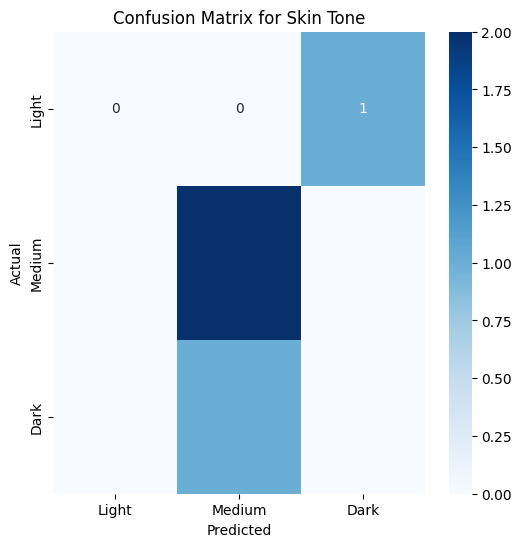

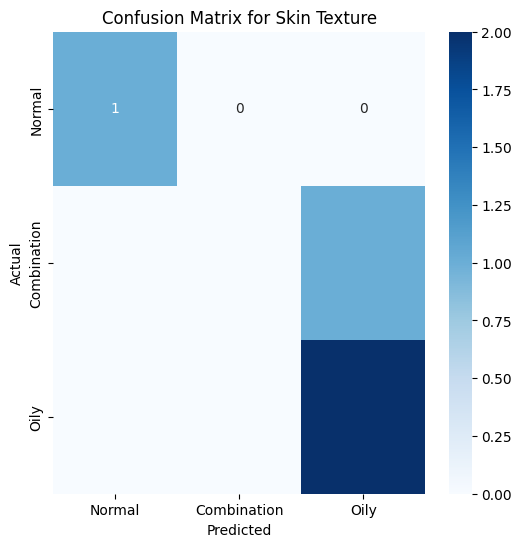

In [46]:
import numpy as np

# Predict on validation set
y_pred_tone, y_pred_texture = model.predict(X_val)

# Convert predictions from probabilities to class labels
y_pred_tone_labels = np.argmax(y_pred_tone, axis=1)
y_pred_texture_labels = np.argmax(y_pred_texture, axis=1)

# Convert true labels to class labels
y_val_tone_labels = np.argmax(y_val_tone, axis=1)
y_val_texture_labels = np.argmax(y_val_texture, axis=1)


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Define class names
tone_classes = ['Light', 'Medium', 'Dark']
texture_classes = ['Normal', 'Combination', 'Oily']

# Plot confusion matrices
plot_confusion_matrix(y_val_tone_labels, y_pred_tone_labels, tone_classes, title='Confusion Matrix for Skin Tone')
plot_confusion_matrix(y_val_texture_labels, y_pred_texture_labels, texture_classes, title='Confusion Matrix for Skin Texture')


In [47]:
y_pred_tone

array([[0.03323172, 0.84640694, 0.12036142],
       [0.01126324, 0.7652972 , 0.22343965],
       [0.03231533, 0.2200961 , 0.7475886 ],
       [0.05731594, 0.50725263, 0.43543145]], dtype=float32)

In [48]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define the labels for skin tone and texture
tone_labels = ['Dark', 'Fair', 'Medium']
texture_labels = ['Combination', 'Normal', 'Oily']

# Function to preprocess the image and predict skin tone and texture
def predict_skin_tone_texture(image_path, model):
    # Step 1: Load and preprocess the image
    img = load_img(image_path, target_size=(128, 128))  # Resize the image
    img_array = img_to_array(img) / 255.0  # Normalize the image (0-1 range)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Step 2: Predict skin tone and texture
    predicted_tone, predicted_texture = model.predict(img_array)

    # Step 3: Convert predictions from one-hot to label
    predicted_tone_label = tone_labels[np.argmax(predicted_tone)]
    print(predicted_tone)
    predicted_texture_label = texture_labels[np.argmax(predicted_texture)]
    print(predicted_texture)
    # Print and return the results
    print(f"Predicted Skin Tone: {predicted_tone_label}")
    print(f"Predicted Skin Texture: {predicted_texture_label}")
    return predicted_tone_label, predicted_texture_label


In [50]:
# Example usage of the function
image_path = '/Users/shreejakikkisetti/Downloads/Dataset/Screen Shot 2024-10-12 at 3.06.20 PM.png'  # Replace with the path to your image
predicted_tone, predicted_texture = predict_skin_tone_texture(image_path, model)


1/1 [==============================] - 0s 23ms/step
[[0.06794385 0.47506902 0.45698708]]
[[0.5063778  0.13501224 0.35861   ]]
Predicted Skin Tone: Fair
Predicted Skin Texture: Combination
